# Предсказание оттока пользователей

**Отток пользователей** $-$ одна из ключевых проблем для компаний, особенно в сферах подписочных сервисов, телекоммуникаций, онлайн-образования и финтехе. Потеря клиентов напрямую влияет на выручку, рентабельность и долгосрочную устойчивость бизнеса. Поэтому своевременное выявление склонных к оттоку пользователей и принятие профилактических мер является важной стратегической задачей.
<br><br>
**Обзор [данных](https://www.kaggle.com/c/advanced-dls-spring-2021/)**:

- *ClientPeriod* — длительность обслуживания клиента в месяцах.
- *MonthlySpending* — ежемесячные расходы клиента.
- *TotalSpent* — общая сумма, потраченная клиентом за всё время.
- *Sex* — пол клиента.
- *IsSeniorCitizen* — является ли клиент пенсионером.
- *HasPartner* — есть ли у клиента сожитель/партнёр.
- *HasChild* — есть ли у клиента дети.
- *HasPhoneService* — подключена ли телефонная связь.
- *HasMultiplePhoneNumbers* — имеет ли клиент несколько номеров.
- *HasInternetService* — тип интернет-подключения.
- *HasOnlineSecurityService* — подключена ли онлайн-защита.
- *HasOnlineBackup* — подключено ли онлайн-резервное копирование.
- *HasDeviceProtection* — есть ли защита устройств.
- *HasTechSupportAccess* — доступ к техподдержке.
- *HasOnlineTV* — подключено ли онлайн-ТВ.
- *HasMovieSubscription* — подписка на фильмы.
- *HasContractPhone* — тип контракта на телефонные услуги.
- *IsBillingPaperless* — использует ли клиент безбумажный платёж.
- *PaymentMethod* — способ оплаты.
- *Churn* — ушёл ли клиент.

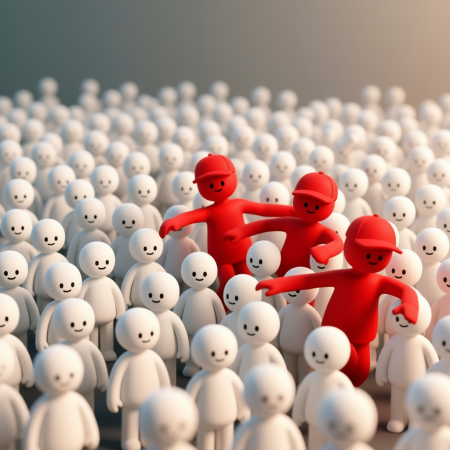

# 0. Импорт библиотек

In [ ]:
!pip install catboost
# !pip install dython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
# from dython.nominal import associations
from sklearn.metrics import roc_auc_score
from scipy.stats import loguniform, uniform
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, cross_validate, StratifiedKFold

from umap import UMAP
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression


# Вспомогательные настройки
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

RANDOM_STATE = 42

# 1. Загрузка и обработка тренировочных данных

In [ ]:
data_train = pd.read_csv('train.csv')

In [ ]:
data_train[:3]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1


In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Для единообразия представления категориальных признаков преобразуем переменную `IsSeniorCitizen` из числового типа в строковый:

In [ ]:
data_train['IsSeniorCitizen'] = data_train['IsSeniorCitizen'].map({0: 'No', 1: 'Yes'})
data_train['IsSeniorCitizen'].dtype

dtype('O')

Преобразуем признак `TotalSpent` к числовому типу и проверим пропуски:

In [ ]:
data_train['TotalSpent'] = pd.to_numeric(data_train['TotalSpent'], errors='coerce')
data_train['TotalSpent'].dtype

dtype('float64')

In [ ]:
mask_TS_nan = data_train['TotalSpent'].isna()
print(f'Всего NaN в признаке TotalSpent: {mask_TS_nan.sum()}')

Всего NaN в признаке TotalSpent: 9


In [ ]:
data_train[mask_TS_nan]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,NaN,Male,No,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,NaN,Female,No,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,NaN,Male,No,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,NaN,Female,No,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,NaN,Female,No,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,NaN,Male,No,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,NaN,Male,No,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,NaN,Female,No,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,NaN,Female,No,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


> В выборке присутствуют клиенты с `ClientPeriod=0`, что может соответствовать новым пользователям.

In [ ]:
# Дополнительно выделим записи по условию ClientPeriod=0
data_train[data_train.ClientPeriod == 0]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,NaN,Male,No,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,NaN,Female,No,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,NaN,Male,No,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,NaN,Female,No,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,NaN,Female,No,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,NaN,Male,No,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,NaN,Male,No,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,NaN,Female,No,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,NaN,Female,No,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


Для клиентов, у которых `ClientPeriod=0` (новые подключения), отсутствующие значения в признаке `TotalSpent` заменяются на значения из столбца `MonthlySpending`. При этом значение `ClientPeriod` для таких клиентов корректируется с 0 на 1:

In [ ]:
data_train['TotalSpent'] = data_train['TotalSpent'].fillna(data_train.MonthlySpending)
data_train.loc[data_train.ClientPeriod == 0, 'ClientPeriod'] = 1

Определение признаков и целевой переменной:

In [ ]:
target = 'Churn'

num_features = ['ClientPeriod', 'MonthlySpending', 'TotalSpent']

cat_features = [
    'Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild',
    'HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService',
    'HasOnlineSecurityService','HasOnlineBackup', 'HasDeviceProtection',
    'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription',
    'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod'
]

# 2. EDA тренировочных данных

## 2.1. Дублирующие записи

In [ ]:
# Дубликаты без учёта целевой переменной
mask_data_duplicates = (
    data_train
    .drop(target, axis=1)
    .duplicated(keep=False)
)

print(
    f'Кол-во дубликатов в данных: {data_train[mask_data_duplicates].shape[0]}'
)

Кол-во дубликатов в данных: 41


In [ ]:
# Подвыборка из дубликатов
data_train[mask_data_duplicates].sort_values(by=['MonthlySpending', target])

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
838,1,19.65,19.65,Female,No,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
1636,1,19.65,19.65,Female,No,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
4811,1,19.65,19.65,Female,No,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,1
3463,1,19.75,19.75,Male,No,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
4294,1,19.75,19.75,Male,No,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,1
3831,1,20.00,20.00,Male,No,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
1647,1,20.00,20.00,Male,No,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,1
594,1,20.05,20.05,Male,No,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
1474,1,20.05,20.05,Male,No,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
3735,1,20.20,20.20,Male,No,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0


> Была выделена подвыборка дублирующихся записей, все они имеют значение признака `ClientPeriod=1`, а также сопровождаются рядом других константных признаков.

## 2.2. Анализ числовых признаков и целевой переменной

### 2.2.1. Распределение целевой переменной

In [ ]:
pd.concat([
    data_train[target].value_counts(),
    data_train[target].value_counts(normalize=True).round(3)
], axis=1)

,count,proportion
Churn,,
0,3898,0.738
1,1384,0.262


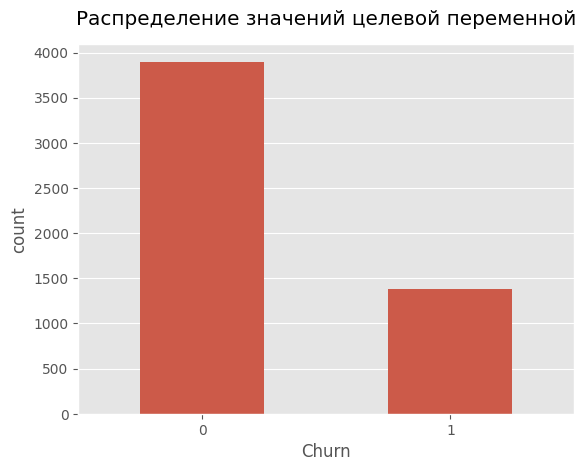

In [ ]:
# Визуализация
sns.countplot(data=data_train, x=target, width=0.5)
plt.title('Распределение значений целевой переменной', y=1.03)
plt.show()

> Наблюдается умеренный дисбаланс классов. Для оценки качества моделей будут использоваться метрики `ROC AUC` (условие конкурса) и `PR AUC`.

### 2.2.2. Распределения числовых признаков

In [ ]:
# Описательные статистики
data_train[num_features].describe()

,ClientPeriod,MonthlySpending,TotalSpent
count,5282.000000,5282.000000,5282.000000
mean,32.398713,64.924754,2287.564824
std,24.548112,30.176464,2268.970866
min,1.000000,18.250000,18.800000
25%,9.000000,35.462500,395.725000
50%,29.000000,70.400000,1405.650000
75%,55.000000,90.050000,3795.212500
max,72.000000,118.750000,8684.800000


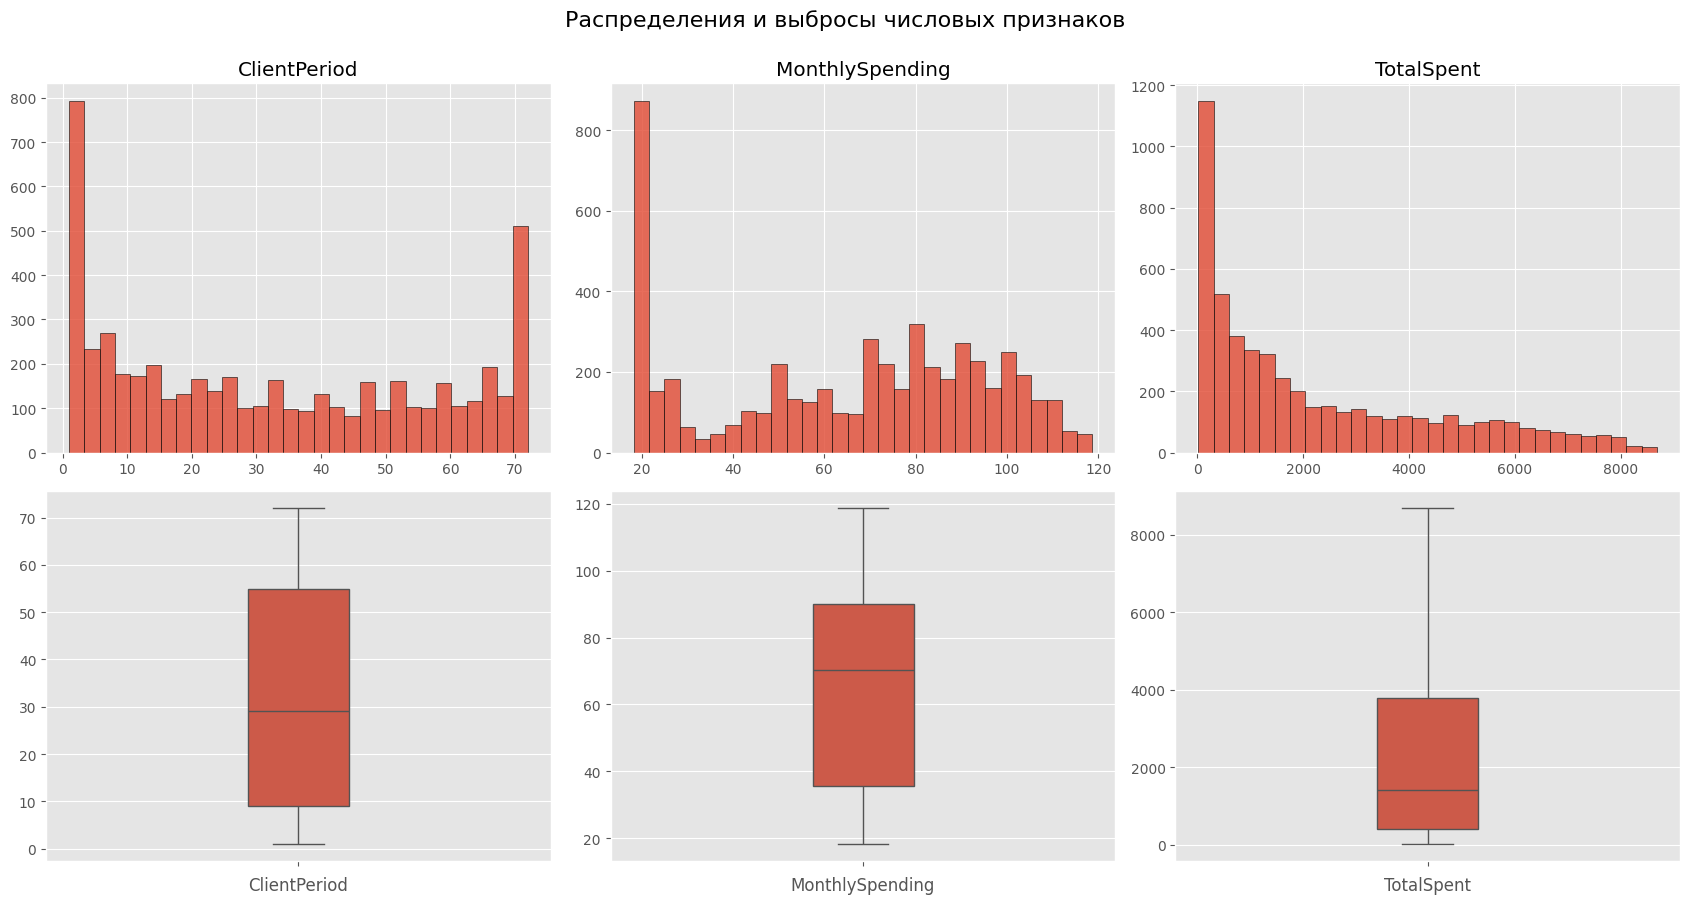

In [ ]:
# Гистограммы и "Ящики с усами"
fig, axes = plt.subplots(2, 3, figsize=(17, 9))

for i in range(len(num_features)):
    # гистограмма
    data_train[num_features[i]].hist(ax=axes[0, i], bins=30, edgecolor='black', alpha=0.8)
    axes[0, i].set_title(num_features[i])

    # boxplot
    sns.boxplot(data=data_train[num_features[i]], ax=axes[1, i], width=0.2)
    axes[1, i].set_ylabel('')
    axes[1, i].set_xlabel(num_features[i])

fig.suptitle('Распределения и выбросы числовых признаков', fontsize=16, y=1)
plt.tight_layout()
plt.show()

> Хотя диаграммы `boxplot` не выявили явных выбросов, признаки имеют различную форму распределения, включая выраженную асимметрию, поэтому логарифмирование перекошенных признаков остаётся целесообразным.

In [ ]:
# Визуализация
fig = px.scatter_3d(
    data_train,
    x=num_features[0],
    y=num_features[1],
    z=num_features[2],
    color=data_train[target].astype('category'),
    opacity=0.8
).update_traces(marker=dict(size=4))

fig.update_layout(
    title='3D-визуализация распределения объектов в пространстве числовых признаков',
    width=1200,
    height=600,
    legend_title_text=target,
    legend=dict(itemsizing='constant')
)

fig.show()

### 2.2.3. Распределения числовых признаков по классам целевой переменной

In [ ]:
# Описательные статистики
pd.concat({
    feat: data_train.groupby(target)[feat].describe().round(2)
    for feat in num_features
}, axis=1)

ClientPeriod                                            MonthlySpending  \
             count   mean    std  min   25%   50%   75%   max           count   
Churn                                                                           
0           3898.0  37.53  24.12  1.0  15.0  37.0  61.0  72.0          3898.0   
1           1384.0  17.95  19.46  1.0   2.0  10.0  29.0  72.0          1384.0   

                                                       TotalSpent           \
        mean    std    min    25%    50%   75%     max      count     mean   
Churn                                                                        
0      61.60  31.27  18.25  25.10  64.78  89.1  118.75     3898.0  2558.02   
1      74.28  24.55  18.95  56.44  79.50  94.2  118.35     1384.0  1525.83   

                                                         
           std   min     25%      50%      75%      max  
Churn                                                    
0      2332.62  18.8  564.46  1709.12  4273.60  8672.45  
1      1881.44  19.1  134.65   706.72  2352.55  8684.80

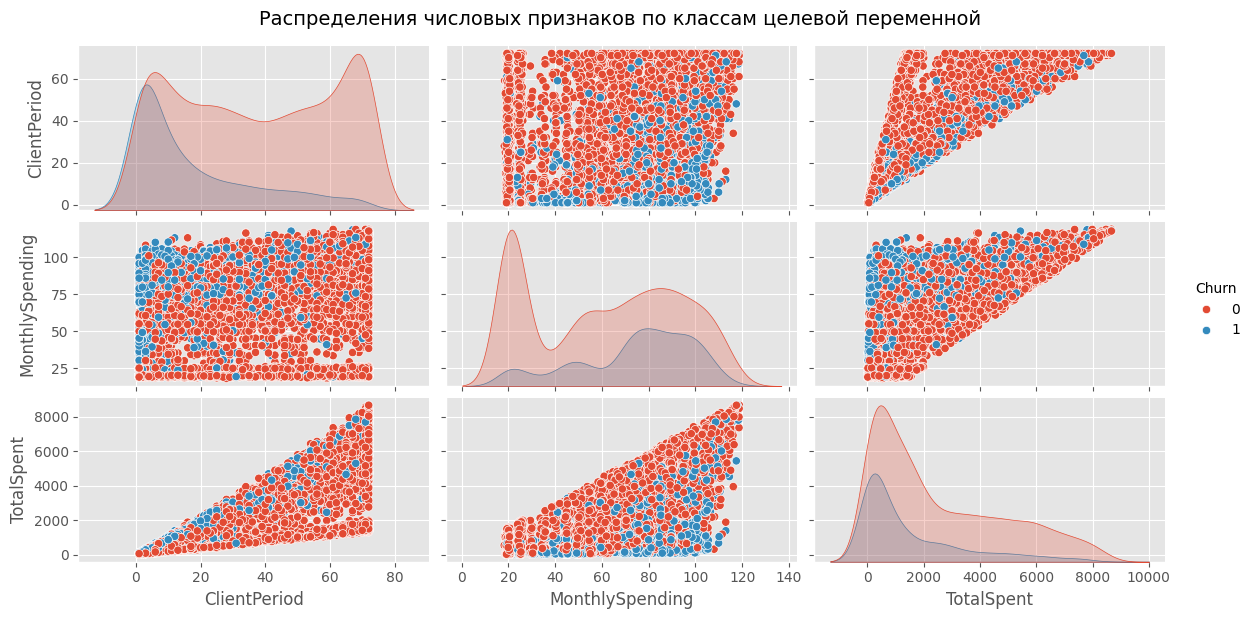

In [ ]:
# Визуализация
g = sns.pairplot(
    data=data_train,
    hue=target,
    diag_kind='kde',
    vars=num_features,
    height=2,
    aspect=2
)

g.fig.suptitle(
    'Распределения числовых признаков по классам целевой переменной',
    fontsize=14,
    y=1.02
)

g.fig.subplots_adjust(top=0.96)
plt.show()

> * Удержание растёт со временем.
> * Высокие ежемесячные расходы $-$ выше риск оттока. Особенно опасны новые клиенты с высокой платой.
> * Чем больше потратили $-$ тем меньше уходят.

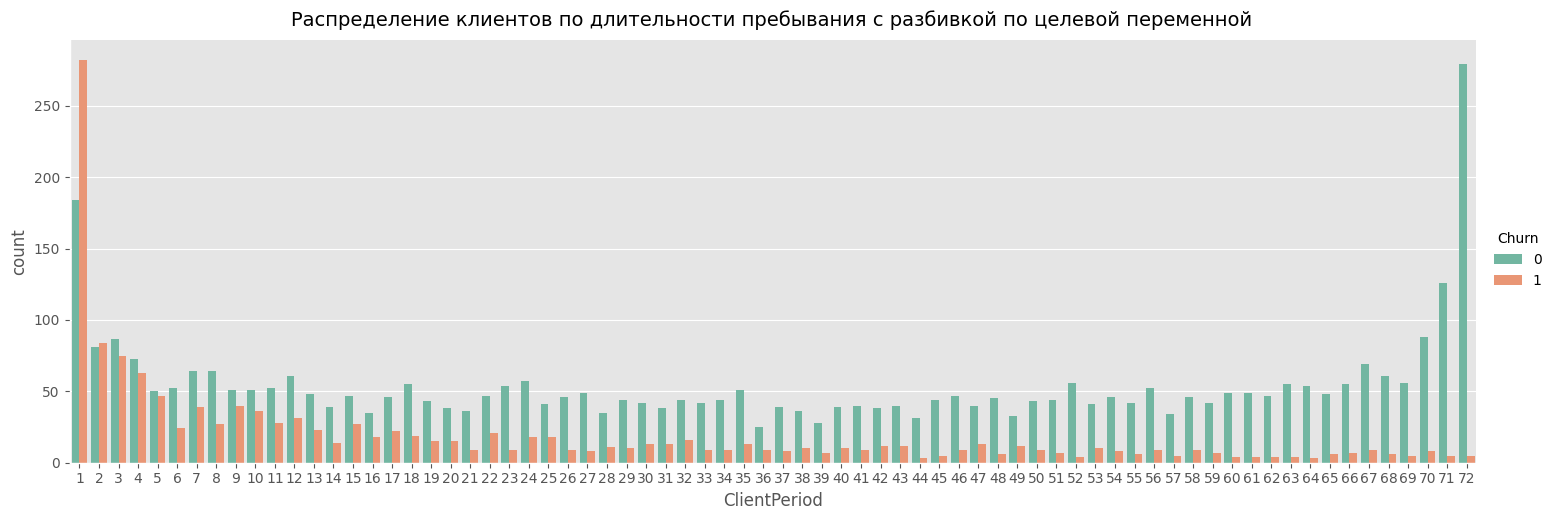

In [ ]:
# Отдельная визуализация для признака ClientPeriod
g = sns.catplot(
    data=data_train,
    x=num_features[0],
    hue=target,
    kind='count',
    height=5,
    aspect=3,
    palette='Set2'
)

g.fig.suptitle(
    'Распределение клиентов по длительности пребывания с разбивкой по целевой переменной',
    fontsize=14, y=1.03
)

plt.show()

> Распределение целевой переменной по значениям признака `ClientPeriod` показывает выраженные различия между классами, что свидетельствует о его потенциальной информативности. Вероятно, генерация нового признака на основе `ClientPeriod` может улучшить качество линейной модели.

### 2.2.4. Корреляция

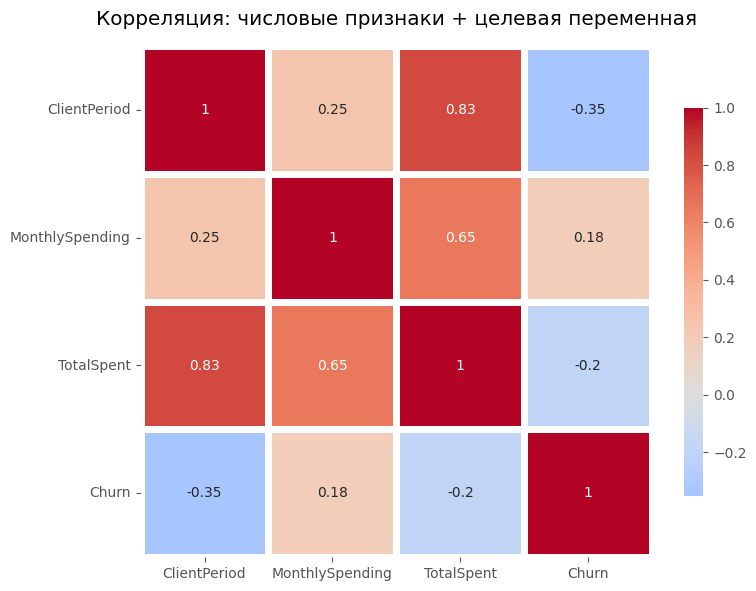

In [ ]:
plt.figure(figsize=(8, 10))

sns.heatmap(
    data_train.drop(cat_features, axis=1).corr(),
    annot=True,
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=5,
    cbar_kws={'shrink': 0.4}
)

plt.title('Корреляция: числовые признаки + целевая переменная', pad=15)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

> `Churn` демонстрирует слабую отрицательную корреляцию с `ClientPeriod` и `TotalSpent`, а также слабую положительную корреляцию с `MonthlySpending`.
Это означает, что клиенты с более длительным периодом взаимодействия и высоким совокупным расходом склонны реже уходить, тогда как более высокие ежемесячные траты ассоциируются с несколько большей вероятностью оттока $-$ хотя все связи слабые.

Отдельно отметим, что признак `TotalSpent` в целом соответствует произведению двух других числовых признаков:
<br>
<br>
$$
TotalSpent \approx ClientPeriod \cdot MonthlySpending
$$

In [ ]:
# Коэффициент согласованности
coef = np.where(
    (data_train.MonthlySpending > 0) & (data_train.ClientPeriod > 0),
    data_train.TotalSpent / (data_train.ClientPeriod * data_train.MonthlySpending),
    0)

pd.Series(coef).describe()

,0
count,5282.000000
mean,1.000012
std,0.050609
min,0.689356
25%,0.979427
50%,1.000000
75%,1.019199
max,1.573454


> В большинстве случаев `TotalSpent` близок к произведению двух других числовых признаков, однако наблюдаются отклонения, что указывает на отсутствие строго мультипликативной связи.
Это может быть связано, например, с изменением тарифов со временем, промо-периодами, разовыми платежами или округлением.

## 2.3. Анализ категориальных признаков

In [ ]:
# Уникальные значения в признаках
data_train[cat_features].apply(
    lambda col: pd.Series({
        'unique_values': col.unique(),
        'n_unique': col.nunique()
    })
).T

,unique_values,n_unique
Sex,"[Male, Female]",2
IsSeniorCitizen,"[No, Yes]",2
HasPartner,"[Yes, No]",2
HasChild,"[Yes, No]",2
HasPhoneService,"[Yes, No]",2
HasMultiplePhoneNumbers,"[No, Yes, No phone service]",3
HasInternetService,"[No, Fiber optic, DSL]",3
HasOnlineSecurityService,"[No internet service, No, Yes]",3
HasOnlineBackup,"[No internet service, No, Yes]",3
HasDeviceProtection,"[No internet service, No, Yes]",3


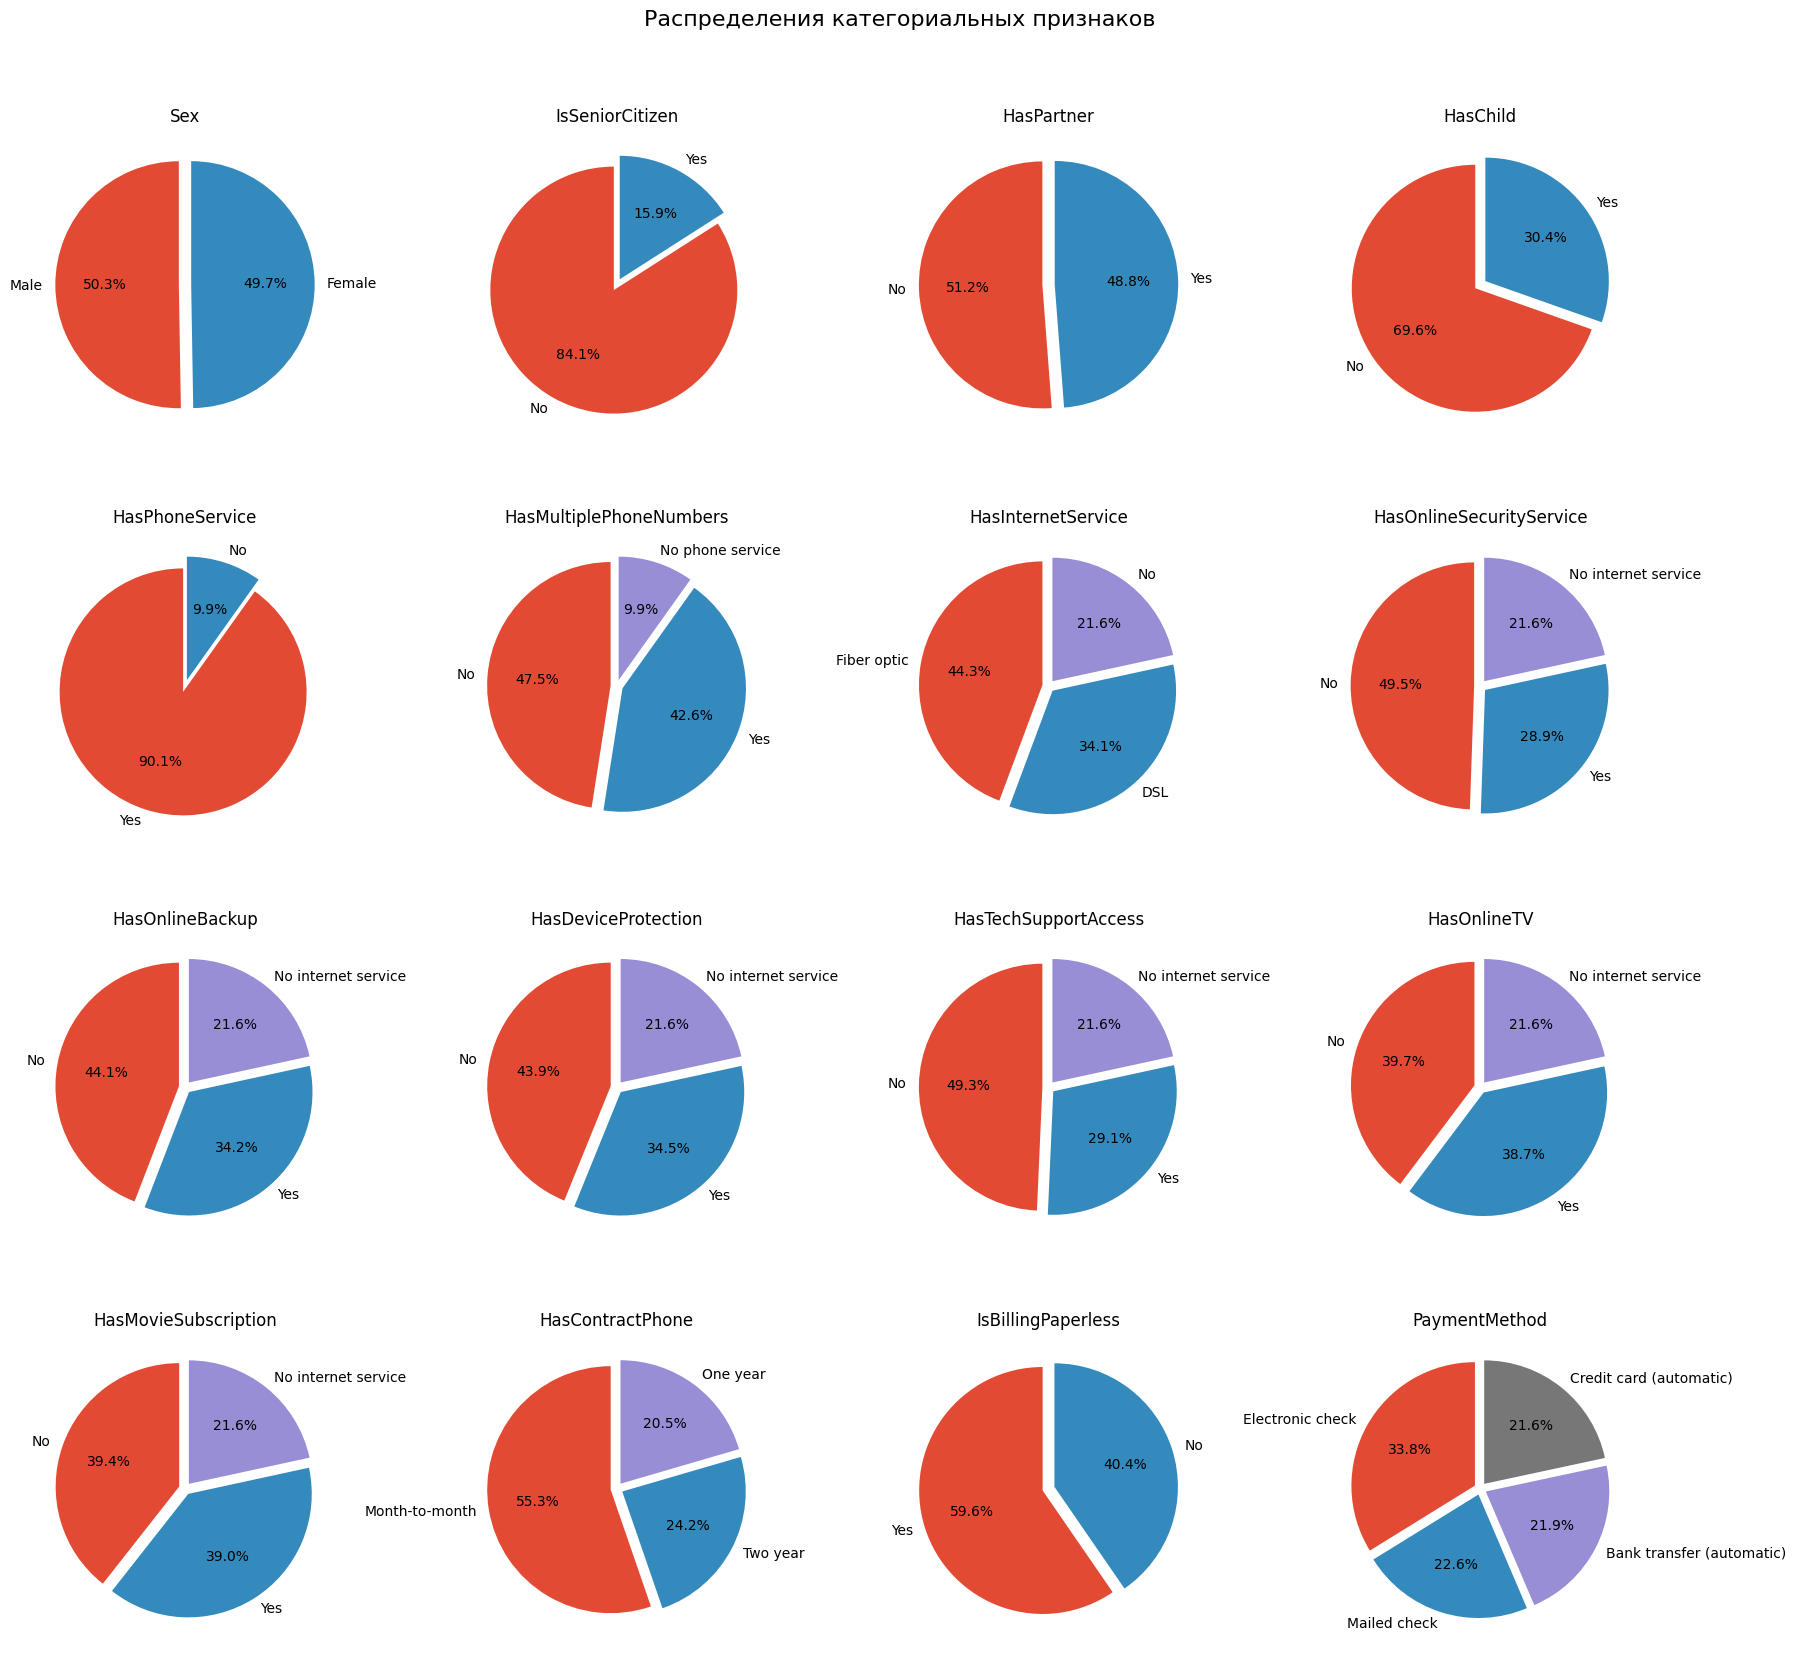

In [ ]:
# Визуализация распределений признаков
n_cols = 4
n_features = len(cat_features)
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
fig.suptitle('Распределения категориальных признаков', fontsize=16, y=1.03)

for i, feature in enumerate(cat_features):
    row = i // n_cols
    col = i % n_cols

    series = data_train[feature].value_counts()
    explode = [0.05] * len(series)

    series.plot.pie(
        autopct='%1.1f%%',
        ax=axes[row][col],
        startangle=90,
        explode=explode
    )
    axes[row][col].set_title(feature, fontsize=12)
    axes[row][col].set_ylabel('')

# # Скрываем лишние subplot'ы
# for i in range(n_features, n_rows * n_cols):
#     row = i // n_cols
#     col = i % n_cols
#     axes[row][col].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

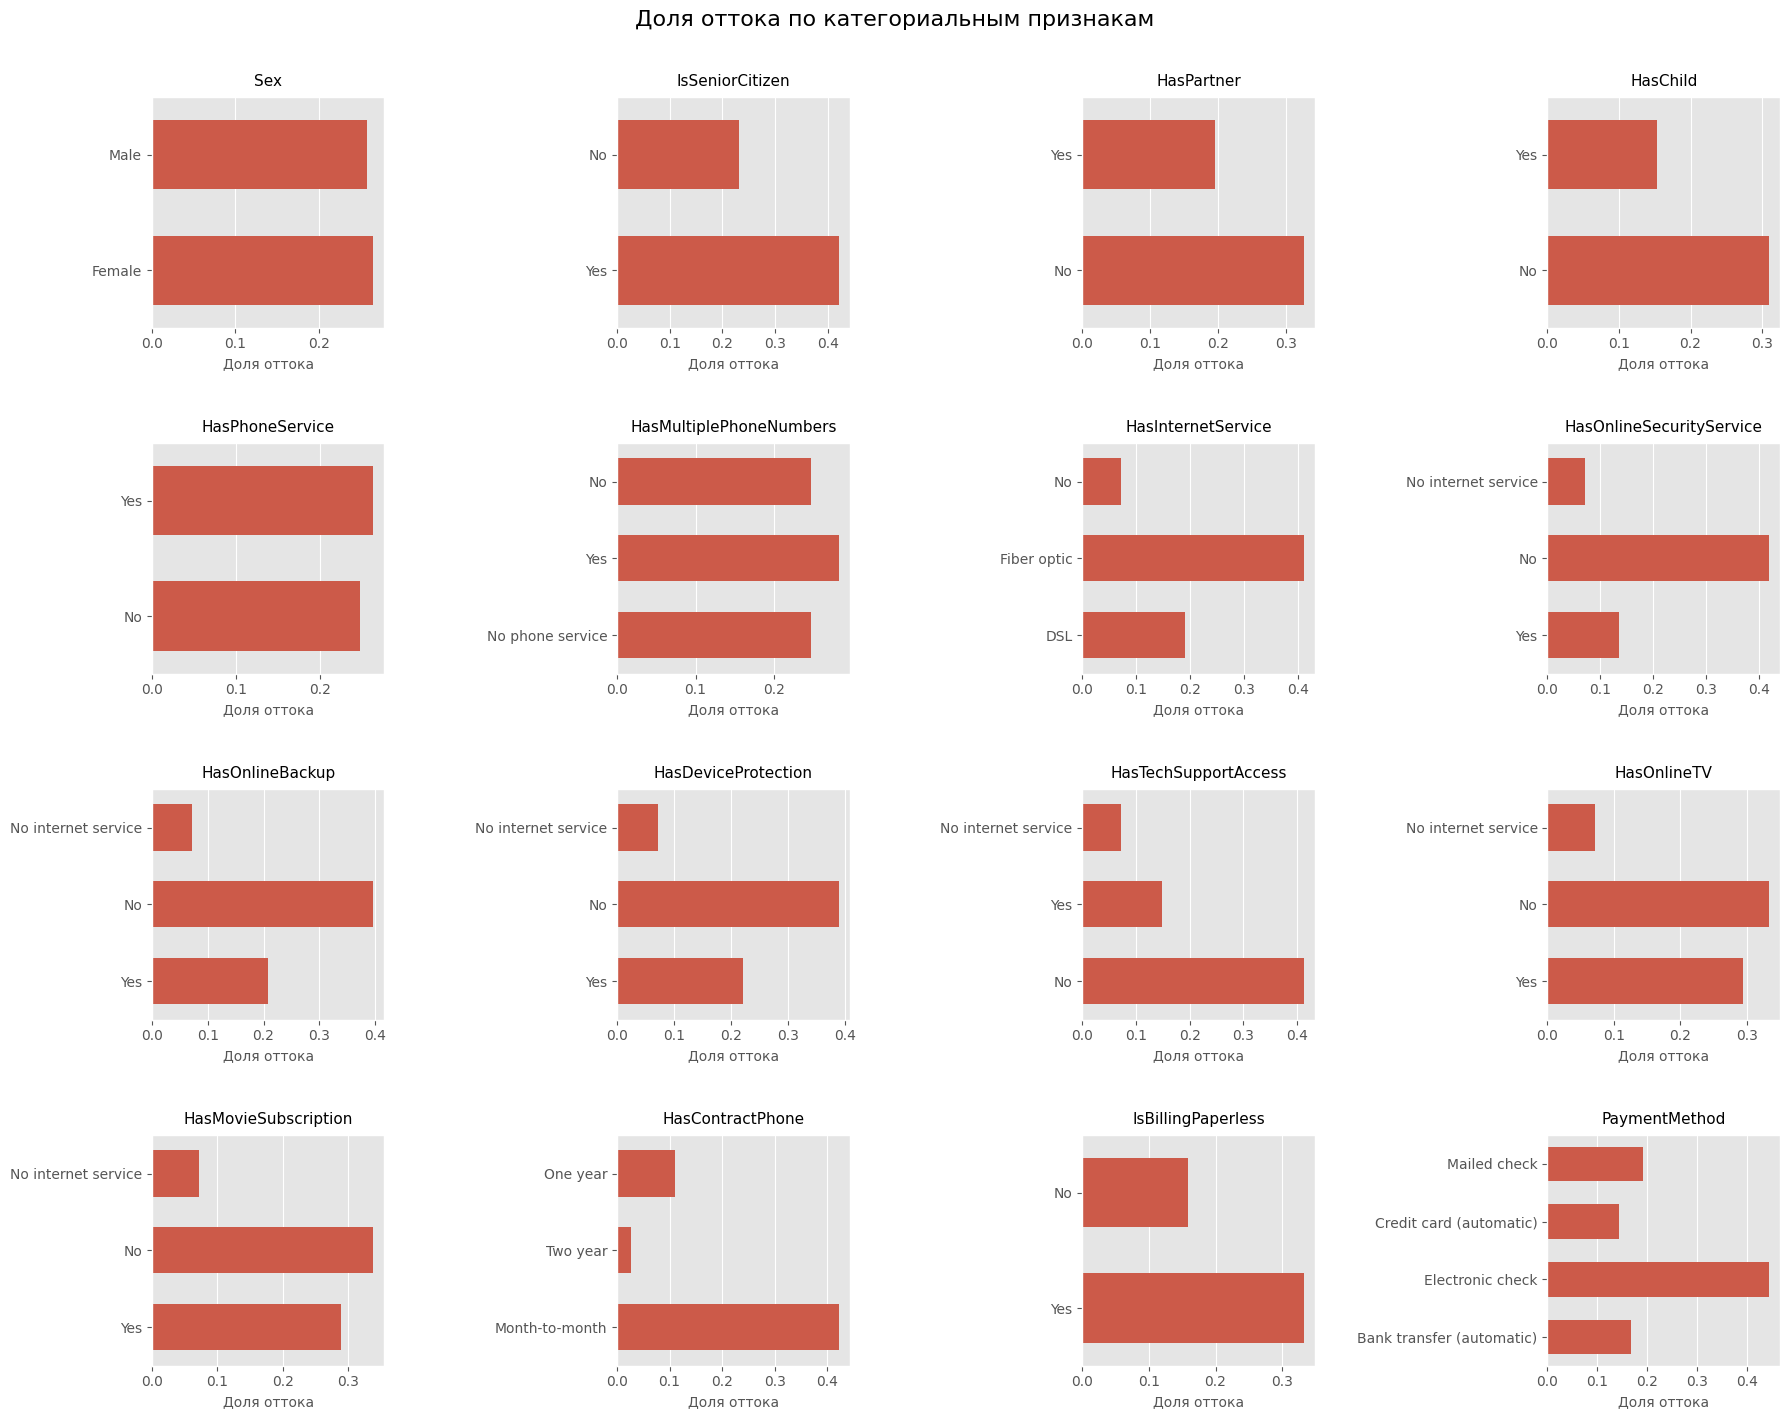

In [ ]:
# Визуализация доли оттока по признакам
n_cols = 4
n_features = len(cat_features)
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 3.5 * n_rows))
fig.suptitle('Доля оттока по категориальным признакам', fontsize=16, y=1.01)

for i, feature in enumerate(cat_features):
    row = i // n_cols
    col = i % n_cols

    sns.barplot(
        data=data_train,
        x=target,
        y=cat_features[i],
        estimator='mean',
        errorbar=None,
        ax=axes[row, col],
        width=0.6
    )
    axes[row, col].set_title(feature, fontsize=11, pad=8)
    axes[row, col].set_xlabel('Доля оттока', fontsize=10)
    axes[row, col].set_ylabel('')

# # Скрываем лишние subplot'ы
# for i in range(n_features, n_rows * n_cols):
#     row = i // n_cols
#     col = i % n_cols
#     axes[row, col].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=1)
plt.show()

Ключевые моменты:
* Отсутствие дополнительных услуг (онлайн-бэкап, защита устройств, техподдержка) повышает вероятность оттока.
* Пожилые клиенты, клиенты без партнёра или детей $-$ более склонны к оттоку.
* Платежи через электронный чек $-$ связаны с самым высоким оттоком.
* Пол, телефонная связь $-$ слабо влияют на отток.
* Некоторые онлайн-услугу (TV, кино) не показывают сильной связи.

## 2.4. Матрица ассоциаций

In [ ]:
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / max(1, min((kcorr - 1), (rcorr - 1))))

def correlation_ratio(categories, values):
    categories = np.array(categories)
    values = np.array(values)
    overall_mean = np.mean(values)
    ssb = 0.0
    ssw = 0.0
    for cat in np.unique(categories):
        cat_mask = (categories == cat)
        cat_vals = values[cat_mask]
        if len(cat_vals) == 0:
            continue
        cat_mean = np.mean(cat_vals)
        ssb += len(cat_vals) * (cat_mean - overall_mean) ** 2
        ssw += np.sum((cat_vals - cat_mean) ** 2)
    if (ssb + ssw) == 0:
        return 0.0
    return np.sqrt(ssb / (ssb + ssw))

def associations(data, nominal_columns=None, compute_only=False):
    """
    Аналог dython.nominal.associations.

    Параметры:
        data: pd.DataFrame
        nominal_columns: список колонок, которые считаются категориальными (включая target)
        compute_only: если True -> не рисует график (как в dython)

    Возвращает:
        словарь с ключом 'corr' -> pd.DataFrame матрицы ассоциаций
    """
    df = data.copy()

    if nominal_columns is None:
        nominal_columns = list(df.select_dtypes(include=['object', 'category']).columns)

    numeric_columns = [c for c in df.columns if c not in nominal_columns]

    # Приводим категориальные к строкам и кодируем числами
    for col in nominal_columns:
        df[col] = df[col].astype(str)

    cols = df.columns
    corr_matrix = pd.DataFrame(index=cols, columns=cols, dtype=np.float64)

    for i, col1 in enumerate(cols):
        for j, col2 in enumerate(cols):
            if i == j:
                corr_matrix.loc[col1, col2] = 1.0
            elif col1 in nominal_columns and col2 in nominal_columns:
                corr_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])
            elif col1 in numeric_columns and col2 in numeric_columns:
                corr_matrix.loc[col1, col2] = df[col1].corr(df[col2], method='pearson')
            else:
                # Один числовой, другой категориальный
                if col1 in nominal_columns:
                    cat, num = df[col1], df[col2]
                else:
                    cat, num = df[col2], df[col1]
                corr_matrix.loc[col1, col2] = correlation_ratio(cat, num)
                corr_matrix.loc[col2, col1] = corr_matrix.loc[col1, col2]

    # Приводим к float
    corr_matrix = corr_matrix.astype(float)

    if not compute_only:
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Матрица ассоциаций')
        plt.show()

    return {'corr': corr_matrix}

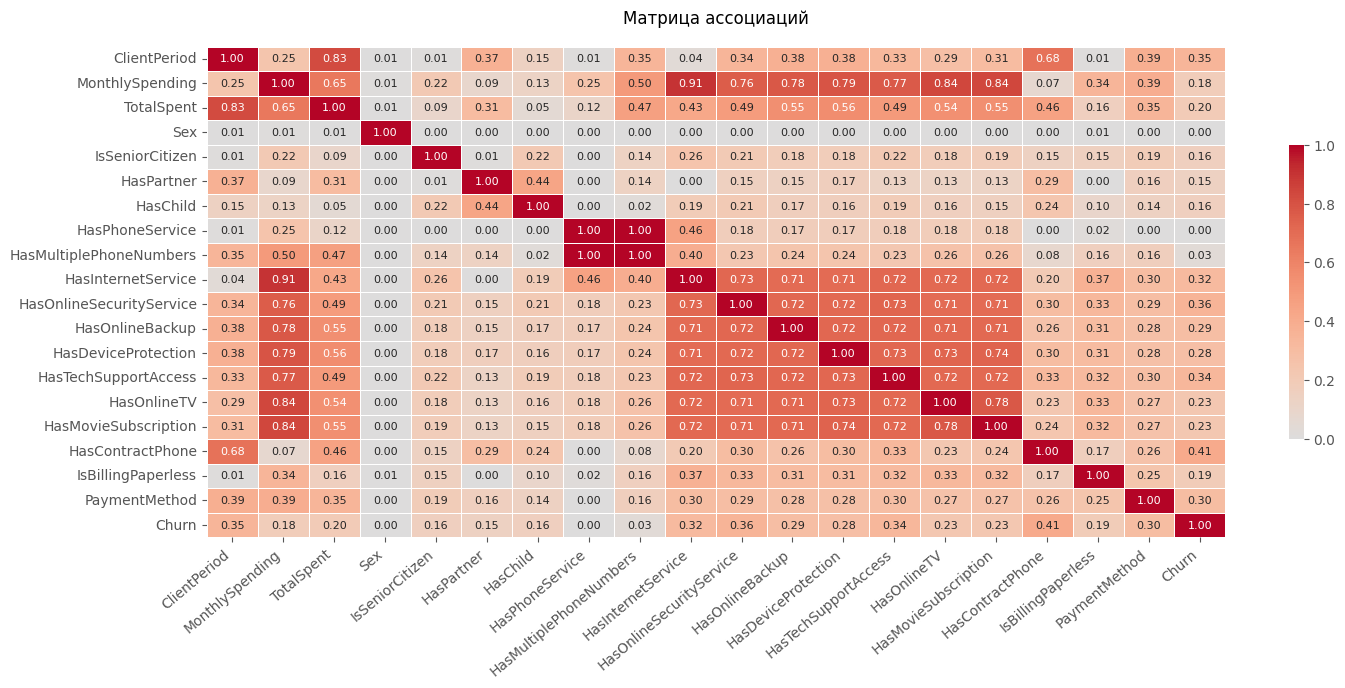

In [ ]:
cat_features_with_target = cat_features + [target]
assoc_result = associations(
    data_train,
    nominal_columns=cat_features_with_target,
    compute_only=True
)

plt.figure(figsize=(15, 7))
sns.heatmap(
    assoc_result['corr'],
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'shrink': 0.6},
    annot_kws={'size': 8}
)
plt.title('Матрица ассоциаций', fontsize=12, y=1.03)
plt.xticks(rotation=40, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

> - Сильная линейная связь между **ClientPeriod** и **TotalSpent**.
> - Группа признаков дополнительных услуг (**HasOnlineSecurityService**, **HasTechSupportAccess**, **HasOnlineBackup**, **HasDeviceProtection**, **HasOnlineTV**, **HasMovieSubscription**) демонстрирует умеренную взаимную корреляцию, что характерно для пакетного подключения услуг $-$ клиенты, покупающие одну дополнительную опцию, часто подключают и другие.
> - Демографические признаки (**Sex**, **IsSeniorCitizen**, **HasPartner**, **HasChild**) имеют низкую предсказательную ценность.
> - Признак **HasContractPhone** умеренно коррелирует с **ClientPeriod**, что логично: более длительные контракты обычно заключаются с клиентами, уже находящимися в сервисе.

## 2.5. Понижение размерности

### 2.5.1. PCA

In [ ]:
# Подготовка данных
X = data_train.drop(columns=[target]).copy()
Y = data_train[target].copy()


# Препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_features)
    ]
)

# Создаем пайплайн: препроцессинг -> PCA
n_components = 3
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=n_components))
])

# Применяем к данным
X_pca = pipeline.fit_transform(X)
pca_step = pipeline.named_steps['pca']
explained_variance_ratio = 100 * pca_step.explained_variance_ratio_


# Визуализация
fig = px.scatter_3d(
    data_train,
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    color=Y.astype('category'),
    opacity=0.8,
    labels={
        'x': f'1ГК ({explained_variance_ratio[0]:.1f}%)',
        'y': f'2ГК ({explained_variance_ratio[1]:.1f}%)',
        'z': f'3ГК ({explained_variance_ratio[2]:.1f}%)'
    }
).update_traces(marker=dict(size=4))

fig.update_layout(
    title='3D-визуализация распределения объектов в пространстве признаков (PCA)',
    width=1200,
    height=600,
    legend_title_text=target,
    legend=dict(itemsizing='constant')
)

fig.show()

In [ ]:
# Разделение точек на группы
cluster_A_idx = (X_pca[:, 0] > 1)
cluster_B_idx = (X_pca[:, 0] < 1)

# DF describe
desc_cluster_A = data_train[cluster_A_idx].drop(columns=cat_features).describe()
desc_cluster_B = data_train[cluster_B_idx].drop(columns=cat_features).describe()

# Сравнение статистик по числовым признакам и таргету для разных групп точек
desc_round = 2
pd.concat(
    {
    'PCA: cluster A':  desc_cluster_A,
    'PCA: cluster B':  desc_cluster_B
    }, axis=1
).round(desc_round)

PCA: cluster A                                     PCA: cluster B  \
        ClientPeriod MonthlySpending TotalSpent    Churn   ClientPeriod   
count        1141.00         1141.00    1141.00  1141.00        4141.00   
mean           30.59           21.14     666.00     0.07          32.90   
std            24.31            2.20     558.79     0.26          24.59   
min             1.00           18.25      18.80     0.00           1.00   
25%             8.00           19.70     161.95     0.00           9.00   
50%            25.00           20.15     511.25     0.00          30.00   
75%            53.00           21.00    1108.80     0.00          56.00   
max            72.00           26.90    2006.95     1.00          72.00   

                                           
      MonthlySpending TotalSpent    Churn  
count         4141.00    4141.00  4141.00  
mean            76.99    2734.37     0.31  
std             22.05    2357.27     0.46  
min             23.45      23.45     0.00  
25%             60.00     575.45     0.00  
50%             79.65    2177.45     0.00  
75%             94.65    4527.45     1.00  
max            118.75    8684.80     1.00

### 2.5.2. UMAP

In [ ]:
# Подготовка данных
X = data_train.drop(columns=[target]).copy()
Y = data_train[target].copy()


# Препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_features)
    ]
)

# Создаем пайплайн: препроцессинг -> UMAP
params = {
    'n_components': 3,
    'n_neighbors': 10,
    'min_dist': 0.1,
    'n_jobs': 1,
    'random_state': RANDOM_STATE
}

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('dim_red', UMAP(**params))
])

# Применяем к данным
X_umap = pipeline.fit_transform(X)


# Визуализация
fig = px.scatter_3d(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    z=X_umap[:, 2],
    color=Y.astype('category'),
    opacity=0.8,
    labels={'x': 'Dim 1', 'y': 'Dim 2', 'z': 'Dim 3'}
).update_traces(marker=dict(size=4))

fig.update_layout(
    title='3D-визуализация распределения объектов в пространстве признаков (UMAP)',
    width=1200,
    height=600,
    legend_title_text=target,
    legend=dict(itemsizing='constant')
)

fig.show()

In [ ]:
# Разделение точек на группы
cluster_A_idx = (X_umap[:, 0] > 10)
cluster_B_idx = (X_umap[:, 0] < 10) & (X_umap[:, 0] > -5) & (X_umap[:, 2] < 4)
cluster_C_idx = (X_umap[:, 0] < 10) & (X_umap[:, 0] > -5) & (X_umap[:, 2] > 4)
cluster_D_idx = (X_umap[:, 0] < -5)

# DF describe
desc_cluster_A = data_train[cluster_A_idx].drop(columns=cat_features).describe()
desc_cluster_B = data_train[cluster_B_idx].drop(columns=cat_features).describe()
desc_cluster_C = data_train[cluster_C_idx].drop(columns=cat_features).describe()
desc_cluster_D = data_train[cluster_D_idx].drop(columns=cat_features).describe()

# Сравнение статистик по числовым признакам и таргету для разных групп точек
desc_round = 2
pd.concat(
    {
    'UMAP: cluster A': desc_cluster_A,
    'UMAP: cluster B': desc_cluster_B,
    'UMAP: cluster C': desc_cluster_C,
    'UMAP: cluster D': desc_cluster_D
    }, axis=1
).round(desc_round)

UMAP: cluster A                                     UMAP: cluster B  \
         ClientPeriod MonthlySpending TotalSpent    Churn    ClientPeriod   
count         1141.00         1141.00    1141.00  1141.00         2355.00   
mean            30.59           21.14     666.00     0.07           32.86   
std             24.31            2.20     558.79     0.26           24.24   
min              1.00           18.25      18.80     0.00            1.00   
25%              8.00           19.70     161.95     0.00            9.00   
50%             25.00           20.15     511.25     0.00           30.00   
75%             53.00           21.00    1108.80     0.00           55.00   
max             72.00           26.90    2006.95     1.00           72.00   

                                          UMAP: cluster C                  \
      MonthlySpending TotalSpent    Churn    ClientPeriod MonthlySpending   
count         2355.00    2355.00  2355.00         1265.00         1265.00   
mean            91.47    3197.80     0.41           33.58           64.44   
std             12.81    2555.97     0.49           25.28           13.36   
min             51.00      69.10     0.00            1.00           42.90   
25%             80.53     802.30     0.00            9.00           54.15   
50%             91.85    2661.10     0.00           30.00           63.90   
75%            101.12    5381.45     1.00           58.00           74.85   
max            118.75    8684.80     1.00           72.00           94.80   

                          UMAP: cluster D                                     
      TotalSpent    Churn    ClientPeriod MonthlySpending TotalSpent   Churn  
count    1265.00  1265.00          521.00          521.00     521.00  521.00  
mean     2384.49     0.17           31.41           42.00    1489.10    0.25  
std      2027.76     0.37           24.44           11.63    1359.02    0.43  
min        42.90     0.00            1.00           23.45      23.45    0.00  
25%       503.25     0.00            8.00           33.45     293.30    0.00  
50%      1912.15     0.00           28.00           40.55    1073.30    0.00  
75%      4014.20     0.00           52.00           50.90    2511.55    0.00  
max      6859.05     1.00           72.00           67.20    4807.45    1.00

> Подбор параметров `UMAP` с акцентом на сохранение локальной структуры данных позволяет выявить скрытую внутреннюю подструктуру: крупный `кластер B`, выделенный ранее с помощью `PCA`, распадается на несколько более мелких подкластеров, что свидетельствует о его неоднородности.

## 2.6. Кластеризация методом DBSCAN

K-distance график:

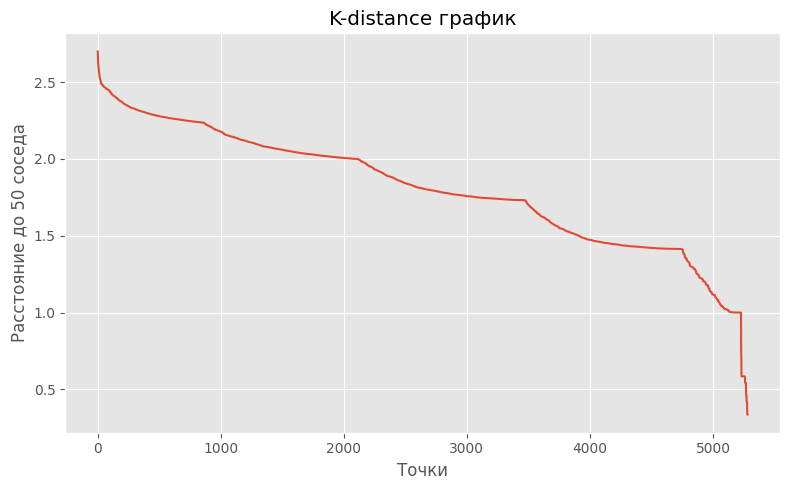

In [ ]:
# Данные
NN_data = data_train.drop(columns=[target]).copy()


# Создание пайплайна
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(sparse_output=False, drop='first'), cat_features)
    ]
)

# Применение пайплайна
X = preprocessor.fit_transform(NN_data)


# K-distance график
n_neighbors = 50
nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)
distances, indices = nbrs.kneighbors(X)
k_distances = sorted(distances[:, -1], reverse=True)

plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.xlabel('Точки')
plt.ylabel(f'Расстояние до {n_neighbors} соседа')
plt.title('K-distance график')
plt.tight_layout()
plt.show()

Кластеризация с предобработкой признаков:

In [ ]:
# Данные и параметры
eps = 2.5
min_samples = 50
DBSCAN_data = data_train.copy()

# Создание и применение пайплайна
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(sparse_output=False, drop='first'), cat_features)
    ]
)

X = preprocessor.fit_transform(DBSCAN_data.drop(columns=[target]))

# Кластеризация
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
DBSCAN_data['clusters'] = dbscan.fit_predict(X)
DBSCAN_data['clusters'].value_counts()

,count
clusters,
1,4141
0,1141


Описательные статистики по кластерам:

In [ ]:
# Маски
msk_cluster_0 = (DBSCAN_data['clusters'] == 0)
msk_cluster_1 = (DBSCAN_data['clusters'] == 1)

# DF describe
desc_cluster_0 = DBSCAN_data[msk_cluster_0].drop(columns=cat_features).describe()
desc_cluster_1 = DBSCAN_data[msk_cluster_1].drop(columns=cat_features).describe()

# Сравнение статистик по числовым признакам и таргету для разных кластеров
desc_round = 2
pd.concat(
    {
    'DBSCAN: cluster 0': desc_cluster_0.iloc[:, :-1],
    'DBSCAN: cluster 1': desc_cluster_1.iloc[:, :-1]
    }, axis=1
).round(desc_round)

DBSCAN: cluster 0                                     DBSCAN: cluster 1  \
           ClientPeriod MonthlySpending TotalSpent    Churn      ClientPeriod   
count           1141.00         1141.00    1141.00  1141.00           4141.00   
mean              30.59           21.14     666.00     0.07             32.90   
std               24.31            2.20     558.79     0.26             24.59   
min                1.00           18.25      18.80     0.00              1.00   
25%                8.00           19.70     161.95     0.00              9.00   
50%               25.00           20.15     511.25     0.00             30.00   
75%               53.00           21.00    1108.80     0.00             56.00   
max               72.00           26.90    2006.95     1.00             72.00   

                                           
      MonthlySpending TotalSpent    Churn  
count         4141.00    4141.00  4141.00  
mean            76.99    2734.37     0.31  
std             22.05    2357.27     0.46  
min             23.45      23.45     0.00  
25%             60.00     575.45     0.00  
50%             79.65    2177.45     0.00  
75%             94.65    4527.45     1.00  
max            118.75    8684.80     1.00

> Результаты кластеризации методом `DBSCAN` согласуются с паттернами, выявленными при визуальном анализе в пространствах пониженной размерности (`PCA` и `UMAP`). `Кластер 1` состоит из более активных и прибыльных клиентов, но они значительно чаще уходят.

Уникальные значения в категориальных признаках по кластерам:

In [ ]:
# Кластер 0
DBSCAN_data.loc[msk_cluster_0, cat_features].apply(
    lambda col: pd.Series({
        'unique_values': col.unique(),
        'n_unique': col.nunique()
    })
).T

,unique_values,n_unique
Sex,"[Male, Female]",2
IsSeniorCitizen,"[No, Yes]",2
HasPartner,"[Yes, No]",2
HasChild,"[Yes, No]",2
HasPhoneService,[Yes],1
HasMultiplePhoneNumbers,"[No, Yes]",2
HasInternetService,[No],1
HasOnlineSecurityService,[No internet service],1
HasOnlineBackup,[No internet service],1
HasDeviceProtection,[No internet service],1


In [ ]:
# Кластер 1
DBSCAN_data.loc[msk_cluster_1, cat_features].apply(
    lambda col: pd.Series({
        'unique_values': col.unique(),
        'n_unique': col.nunique()
    })
).T

,unique_values,n_unique
Sex,"[Male, Female]",2
IsSeniorCitizen,"[No, Yes]",2
HasPartner,"[No, Yes]",2
HasChild,"[No, Yes]",2
HasPhoneService,"[Yes, No]",2
HasMultiplePhoneNumbers,"[No, Yes, No phone service]",3
HasInternetService,"[Fiber optic, DSL]",2
HasOnlineSecurityService,"[No, Yes]",2
HasOnlineBackup,"[No, Yes]",2
HasDeviceProtection,"[No, Yes]",2


# 3. Загрузка и обработка тестовых данных

In [ ]:
data_test = pd.read_csv('test.csv')

In [ ]:
data_test[:3]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check


In [ ]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

Изменим тип данных у признаков `IsSeniorCitizen` и `TotalSpent`, а также проверим наличие пропущенных значений в `TotalSpent`:

In [ ]:
data_test['IsSeniorCitizen'] = data_test.IsSeniorCitizen.map({0: 'No', 1: 'Yes'})
data_test['IsSeniorCitizen'].dtype

dtype('O')

In [ ]:
data_test['TotalSpent'] = pd.to_numeric(data_test.TotalSpent, errors='coerce')
data_test['TotalSpent'].dtype

dtype('float64')

In [ ]:
mask_TS_nan = data_test['TotalSpent'].isna()
print(f'Всего NaN в признаке TotalSpent: {mask_TS_nan.sum()}')

Всего NaN в признаке TotalSpent: 2


In [ ]:
data_test[mask_TS_nan]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
177,0,19.85,NaN,Male,No,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
767,0,20.25,NaN,Male,No,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check


In [ ]:
data_test['TotalSpent'] = data_test['TotalSpent'].fillna(data_test.MonthlySpending)
data_test.loc[data_test.ClientPeriod == 0, 'ClientPeriod'] = 1

Выполним проверку соответствия признаков в тестовом и обучающем датафреймах:

In [ ]:
if data_test.columns.equals(data_train.drop(columns=[target]).columns):
    print('Столбцы в train и test датафреймах совпадают.')
else:
    print('Столбцы в train и test датафреймах НЕ совпадают.')

Столбцы в train и test датафреймах совпадают.


Описательные статистики для числовых признаков:

In [ ]:
data_test[num_features].describe()

,ClientPeriod,MonthlySpending,TotalSpent
count,1761.000000,1761.000000,1761.000000
mean,32.294719,64.272601,2256.505906
std,24.592266,29.832517,2260.479152
min,1.000000,18.550000,18.850000
25%,9.000000,35.650000,405.600000
50%,29.000000,70.050000,1356.300000
75%,56.000000,89.400000,3759.050000
max,72.000000,117.350000,8496.700000


Уникальные значения в категориальных признаках:

In [ ]:
data_test[cat_features].apply(
    lambda col: pd.Series({
        'unique_values': col.unique(),
        'n_unique': col.nunique()
    })
).T

,unique_values,n_unique
Sex,"[Male, Female]",2
IsSeniorCitizen,"[No, Yes]",2
HasPartner,"[Yes, No]",2
HasChild,"[No, Yes]",2
HasPhoneService,"[Yes, No]",2
HasMultiplePhoneNumbers,"[Yes, No, No phone service]",3
HasInternetService,"[DSL, Fiber optic, No]",3
HasOnlineSecurityService,"[Yes, No, No internet service]",3
HasOnlineBackup,"[No, Yes, No internet service]",3
HasDeviceProtection,"[No, Yes, No internet service]",3


# 4. Логистическая регрессия

In [ ]:
# Данные для обучения и теста
LR_train = data_train.copy()
LR_test = data_test.copy()

In [ ]:
# Стратифицированная кросс-валидация с перемешиванием для сохранения пропорций классов
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

## 4.1. Создание признака: TenureGroup

`TenureGroup` $-$ это новый категориальный признак, представляющий группу клиента по длительности его взаимодействия с сервисом. Он создаётся на основе исходного числового признака `ClientPeriod` путём разбиения его значений на интервалы. Такое преобразование может помочь моделям лучше улавливать нелинейную зависимость между длительностью взаимодействия и целевой переменной.

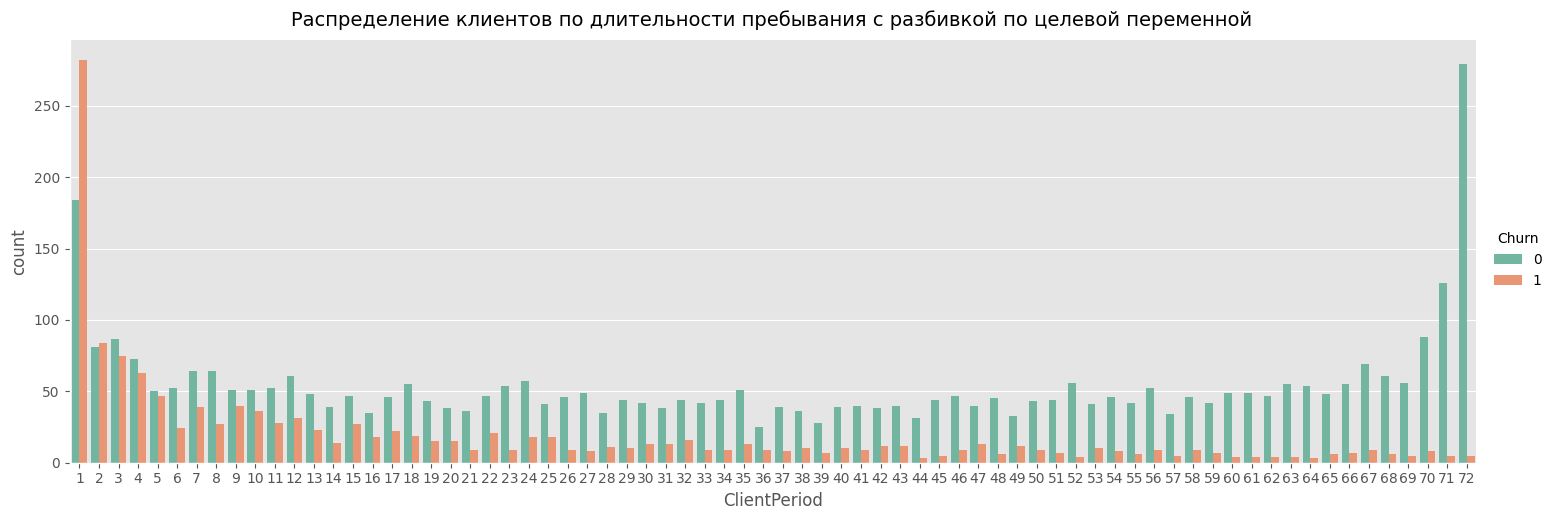

In [ ]:
def add_tenure_group(df, bins, labels, new_col_name='TenureGroup', tenure_col='ClientPeriod'):
    df = df.copy()
    df[new_col_name] = pd.cut(
        df[tenure_col],
        bins=bins,
        labels=labels,
        ordered=False,   # отключаем порядок
        right=False      # интервалы вида [bin_left, bin_right)
    ).astype('object')

    return df

In [ ]:
# Создание промежуточного признака TenureGroup для анализа
bins = [0, 2, 3, 4, 6, 12, 73, np.inf]
labels = ['<2m', '2m', '3m', '4-5m', '6-11m', '12-72m', '73m+']
df = add_tenure_group(LR_train, bins, labels)
cat_features_with_target += ['TenureGroup']

Уровень оттока в каждой группе **TenureGroup**:

In [ ]:
df.groupby('TenureGroup')['Churn'].mean().sort_values(ascending=False)

,Churn
TenureGroup,
<2m,0.605150
2m,0.509091
4-5m,0.472103
3m,0.462963
6-11m,0.367424
12-72m,0.171406


Матрица ассоциаций:

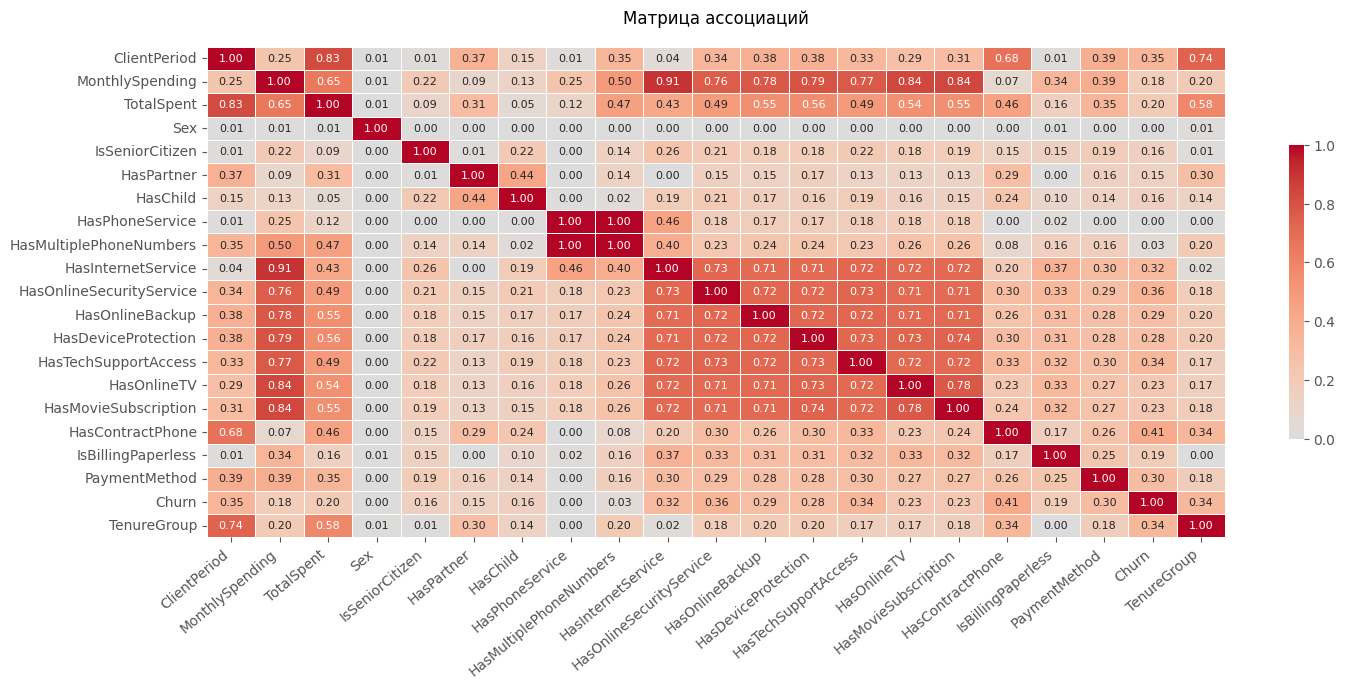

In [ ]:
assoc_result = associations(
    df,
    nominal_columns=cat_features_with_target,
    compute_only=True
)

plt.figure(figsize=(15, 7))
sns.heatmap(
    assoc_result['corr'],
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'shrink': 0.6},
    annot_kws={'size': 8}
)
plt.title('Матрица ассоциаций', fontsize=12, y=1.03)
plt.xticks(rotation=40, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 4.2. Создание альтернативных версий тренировочных наборов данных

In [ ]:
# Параметры для создания признака 'TenureGroup'
bins = [0, 2, 3, 4, 6, 12, 73, np.inf]
labels = ['<2m', '2m', '3m', '4-5m', '6-11m', '12-72m', '73m+']


# ПОДМНОЖЕСТВА ПРИЗНАКОВ
X0 = LR_train[num_features[:-1]].copy()                                # только числовые фичи 'ClientPeriod' и 'MonthlySpending'
X1 = LR_train[num_features].copy()                                     # все три числовые фичи
X2 = np.log1p(LR_train[num_features])                                  # log(трёх числовых фич)

X3 = LR_train.drop(columns=[target]).copy()                            # все исходные фичи
X4 = LR_train.drop(columns=[target]).copy()                            # все исходные фичи и log(числовых фич)
X4[num_features] = np.log1p(X4[num_features])

X5 = LR_train.drop(columns=[target]).copy()                            # все исходные фичи + 'TenureGroup'
X5 = add_tenure_group(X5, bins, labels)

X6 = LR_train.drop(columns=[target]).copy()                            # все исходные фичи и log(числовых фич) + 'TenureGroup'
X6 = add_tenure_group(X6, bins, labels)
X6[num_features] = np.log1p(X6[num_features])

X7 = LR_train.drop(columns=[target, 'Sex', 'HasPhoneService']).copy()  # все исходные фичи [без 'Sex' и 'HasPhoneService'] + 'TenureGroup'
X7 = add_tenure_group(X7, bins, labels)

X8 = LR_train.drop(columns=[target, 'Sex', 'HasPhoneService']).copy()  # все исходные фичи [без 'Sex' и 'HasPhoneService'] и log(числовых фич) + 'TenureGroup'
X8 = add_tenure_group(X8, bins, labels)
X8[num_features] = np.log1p(X8[num_features])


# ТАРГЕТ
Y = LR_train[target].copy()


# ДАТАСЕТЫ ДЛЯ ОБУЧЕНИЯ
datasets_0_2 = {
    'X0': (X0, Y),
    'X1': (X1, Y),
    'X2': (X2, Y)
}

datasets_3_6 = {
    'X3': (X3, Y),
    'X4': (X4, Y),
    'X5': (X5, Y),
    'X6': (X6, Y),
    'X7': (X7, Y),
    'X8': (X8, Y)
}

> Признаки `Sex` и `HasPhoneService` были исключены из некоторых датасетов на основании анализа матрицы ассоциаций, так как они демонстрируют крайне низкую связь с целевой переменной.

## 4.3. Бейзлайн-модели

Используем упрощённые версии датасетов и логистическую регрессию "из коробки":

In [ ]:
datasets = datasets_0_2

print(f'Средний ROC AUC по {n_splits} фолдам:')
for name, (X, y) in datasets.items():

    cv_scores = cross_val_score(
        LogisticRegression(),
        X, y,
        cv=skf,
        scoring='roc_auc'
    )

    print(
        f'> набор данных {name}: {np.mean(cv_scores):.6f} \u00b1 {np.std(cv_scores):.6f}',
        sep='\n'
    )

Средний ROC AUC по 5 фолдам:
> набор данных X0: 0.804319 ± 0.023740
> набор данных X1: 0.804795 ± 0.023665
> набор данных X2: 0.806452 ± 0.023129


## 4.4. Подбор гиперпараметров логистической регрессии с кросс-валидацией (итоговое предсказание)

### 4.4.1. Пространство гиперпараметров

In [ ]:
C_distribution = loguniform(1e-5, 1e5)
l1_ratio_distribution = uniform(0, 1.0)

param_distributions = [

    {
        'classifier__penalty': ['l1'],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__C': C_distribution
    },

    {
        'classifier__penalty': ['l2'],
        'classifier__solver': ['liblinear', 'lbfgs', 'sag', 'saga'],
        'classifier__C': C_distribution
    },

    {
        'classifier__penalty': [None],
        'classifier__solver': ['lbfgs', 'sag', 'saga'],
        'classifier__C': [1.0]
    },

    {
        'classifier__penalty': ['elasticnet'],
        'classifier__solver': ['saga'],
        'classifier__C': C_distribution,
        'classifier__l1_ratio': l1_ratio_distribution
    }
]

### 4.4.2. Рандомизированный поиск гиперпараметров с препроцессингом

Для каждого расширенного набора признаков:
* Автоматически определяются категориальные фичи
* Строится пайплайн: масштабирование числовых + OHE категориальных
* Подбираются гиперпараметры через RandomizedSearchCV
* Выводятся: средние ROC AUC и PR AUC $\pm$ std, а также лучшие параметры

In [ ]:
n_iter = 20                  # для RandomizedSearchCV()
max_iter = 1000              # для LogisticRegression()
datasets = datasets_3_6
class_weight = {0: 1, 1: 2.8}
scoring = {
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision'
}

print(f'CV = {n_splits}', end=2*'\n' + 150*'=' + 2*'\n')

for name, (X, y) in datasets.items():

    cat_features_ = X.select_dtypes(include=['object']).columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_features),
            ('cat', OneHotEncoder(drop='first'), cat_features_)
        ]
    )


    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=max_iter, random_state=RANDOM_STATE, class_weight=class_weight))
    ])


    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring=scoring,
        cv=skf,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        refit='roc_auc',
        return_train_score=False
    )


    random_search.fit(X, y)

    best_index = random_search.best_index_
    best_params = random_search.best_params_

    mean_roc_auc = random_search.cv_results_['mean_test_roc_auc'][best_index]
    std_roc_auc = random_search.cv_results_['std_test_roc_auc'][best_index]

    mean_pr_auc = random_search.cv_results_['mean_test_pr_auc'][best_index]
    std_pr_auc = random_search.cv_results_['std_test_pr_auc'][best_index]


    print(
        f'Набор признаков:   {name}',
        f'ROC AUC:           {mean_roc_auc:.5f} \u00b1 {std_roc_auc:.5f}',
        f'PR AUC:            {mean_pr_auc:.5f} \u00b1 {std_pr_auc:.5f}',
        f'Параметры:         {best_params}',
        sep='\n',
        end=2*'\n' + 150*'=' + 2*'\n'
    )

CV = 5


Набор признаков:   X3
ROC AUC:           0.84479 ± 0.02027
PR AUC:            0.65334 ± 0.02678
Параметры:         {'classifier__C': np.float64(1.7690764556597112), 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}


Набор признаков:   X4
ROC AUC:           0.84920 ± 0.01905
PR AUC:            0.66908 ± 0.02291
Параметры:         {'classifier__C': np.float64(0.31988400122756283), 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}


Набор признаков:   X5
ROC AUC:           0.84886 ± 0.01910
PR AUC:            0.67076 ± 0.02257
Параметры:         {'classifier__C': np.float64(0.31988400122756283), 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}


Набор признаков:   X6
ROC AUC:           0.84911 ± 0.01860
PR AUC:            0.66958 ± 0.02126
Параметры:         {'classifier__C': np.float64(0.31988400122756283), 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}


Набор признаков:   X7
ROC AUC:           0.84897 ± 0.01924
PR AUC:            0

### 4.4.3. Итоговое предсказание

Для финального предсказания используется конфигурация признаков `X8` и соответствующие оптимальные гиперпараметры. Все трансформации, применённые к обучающим данным, точно воспроизводятся на тестовых:

In [ ]:
# Параметры для создания признака 'TenureGroup'
bins = [0, 2, 3, 4, 6, 12, 73, np.inf]
labels = ['<2m', '2m', '3m', '4-5m', '6-11m', '12-72m', '73m+']

# Подготовка данных для обучения и предсказания
X_train, Y_train = X8, Y
X_test = LR_test.drop(columns=['Sex', 'HasPhoneService']).copy()
X_test = add_tenure_group(X_test, bins, labels)
X_test[num_features] = np.log1p(X_test[num_features])


# Настройка
max_iter = 1000
class_weight = {0: 1, 1: 2.8}
cat_features_ = X_train.select_dtypes(include=['object']).columns
BEST_PARAMS = {
    'C': 0.31988400122756283,
    'penalty': 'l1',
    'solver': 'saga',
    'random_state': RANDOM_STATE,
    'max_iter': max_iter,
    'class_weight': class_weight
}


# Создание препроцессинга
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first'), cat_features_)
    ]
)


# Создание пайплайна
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(**BEST_PARAMS))
])


# Обучение и предсказание
model.fit(X_train, Y_train)
y_proba = model.predict_proba(X_test)[:, 1]


# Формирование submission-файла
submission_logreg = pd.DataFrame({
    'Id': range(len(X_test)),
    target: y_proba
})

submission_logreg.to_csv('submission_logreg.csv', index=False)


# Визуализация коэффициентов
preprocessor = model.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()
lr_model = model.named_steps['classifier']
coefficients = lr_model.coef_[0]
pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values('coefficient', key=abs, ascending=False)

,feature,coefficient
23,cat__HasContractPhone_Two year,-1.737533
8,cat__HasInternetService_Fiber optic,0.792537
0,num__ClientPeriod,-0.713713
22,cat__HasContractPhone_One year,-0.661074
6,cat__HasMultiplePhoneNumbers_No phone service,0.398806
11,cat__HasOnlineSecurityService_Yes,-0.382647
7,cat__HasMultiplePhoneNumbers_Yes,0.375265
24,cat__IsBillingPaperless_Yes,0.374437
32,cat__TenureGroup_<2m,0.369174
26,cat__PaymentMethod_Electronic check,0.318494


> Как и ожидалось, в ходе подбора гиперпараметров была выбрана модель с `L1-регуляризацией`, которая автоматически выполнила отбор наиболее информативных признаков. В частности, среди числовых переменных значимым оказался только `ClientPeriod`, тогда как `MonthlySpending` и `TotalSpent` получили нулевые коэффициенты. В целях упрощения и повышения интерпретируемости модели можно изначально исключить эти "занулённые" признаки: это приведёт лишь к незначительному снижению метрики качества, но сделает структуру модели более прозрачной и лаконичной. Кроме того, целесообразно пересмотреть границы интервалов при формировании признака `TenureGroup`.

Ответ проверяющей системы:

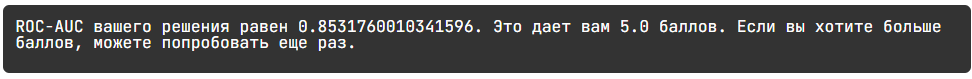

# 5. CatBoost

Перед тем как приступить к решению задачи классификации, стоит отметить, что данная задача размещена на Kaggle $-$ значит, доступны публичные ноутбуки участников, включая реализации на основе CatBoost. Анализ этих решений показывает, что лучшие результаты, достигнутые с помощью CatBoost по целевой метрике, находятся в диапазоне 0.855 $-$ 0.856.

В данном случае я не буду проводить глубокий подбор гиперпараметров: хотя такие эксперименты и предпринимались, они не принесли значимого улучшения качества, которое оправдало бы дополнительные затраты времени и вычислительных ресурсов. Вместо этого я ограничусь логичным, интуитивно обоснованным подходом и минимальной, но осмысленной настройкой модели $-$ с акцентом на воспроизводимость, прозрачность и разумное соотношение усилий и результата.

In [ ]:
# ?CatBoostClassifier

In [ ]:
# Данные для обучения и теста
X_train = data_train.drop(columns=[target]).copy()
Y_train = data_train[target].copy()
X_test = data_test.copy()

In [ ]:
# Стратифицированная кросс-валидация с перемешиванием для сохранения пропорций классов
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

У нас имеется набор данных, содержащий около 5_300 наблюдений и 19 признаков, из которых лишь 3 являются числовыми, а остальные 16 — категориальными. При этом максимальное количество уникальных значений в любом из категориальных признаков не превышает 4-х, что свидетельствует о простой и компактной структуре категорий.

Учитывая относительно небольшой объём выборки и высокую гибкость модели CatBoost, существует значительный риск переобучения. Это особенно актуально в условиях сложного пространства гиперпараметров CatBoost, где даже незначительные изменения могут привести к чрезмерной адаптации модели к обучающей выборке в ущерб её обобщающей способности.

Ранее применённая логистическая регрессия показала результат около 0.853. Это также позволяет предположить, что данные обладают некоторой линейной разделимостью. Следовательно, использование излишне сложных моделей может быть не просто неоправданным, но и контрпродуктивным.

В связи с этим было принято решение отказаться от агрессивной настройки гиперпараметров CatBoost и начать с построения консервативного бейзлайна. Для этого заданы следующие начальные ограничения:

* `one_hot_max_size=2`: one-hot-кодирование применяется только к категориальным признакам с не более чем двумя уникальными значениями. Остальные признаки обрабатываются через CTR-статистики. Такой подход оказался значительно эффективнее принудительного one-hot-кодирования всех категориальных переменных, которое ранее приводило к снижению качества: оно блокировало возможность CatBoost использовать одно из своих ключевых преимуществ $-$ адаптивное кодирование на основе целевой переменной.

* `max_ctr_complexity=2`: максимальная сложность CTR-признаков ограничена комбинациями не более чем из двух категориальных переменных. Это позволяет избежать построения излишне сложных взаимодействий, которые при малом объёме данных легко переобучаются на шуме или редких сочетаниях.

Таким образом, мы получаем стартовую модель:

In [ ]:
X, Y = X_train, Y_train

model = CatBoostClassifier(
    verbose=False,
    cat_features=cat_features,
    random_state=RANDOM_STATE,
    eval_metric='AUC',
    one_hot_max_size=2,
    max_ctr_complexity=2
)

cv_results = cross_validate(
    model,
    X, Y,
    cv=skf,
    scoring=['roc_auc', 'average_precision']
)

mean_roc_auc = cv_results['test_roc_auc'].mean()
std_roc_auc = cv_results['test_roc_auc'].std()

mean_pr_auc = cv_results['test_average_precision'].mean()
std_pr_auc = cv_results['test_average_precision'].std()

print(
    f'ROC AUC (cv={n_splits}):  {mean_roc_auc:.5f} \u00b1 {std_roc_auc:.5f}',
    f'PR AUC  (cv={n_splits}):  {mean_pr_auc:.5f} \u00b1 {std_pr_auc:.5f}',
    sep='\n'
)


# # Формирование submission-файла
# model.fit(X, Y)
# predictions = model.predict_proba(X_test)[:, 1]
# submission = pd.DataFrame({
#     'Id': range(len(predictions)),
#     'Churn': predictions
# })
# submission.to_csv('submission_catboost_0.csv', index=False)

ROC AUC (cv=5):  0.84245 ± 0.02022
PR AUC  (cv=5):  0.65935 ± 0.02460


Ответ проверяющей системы:

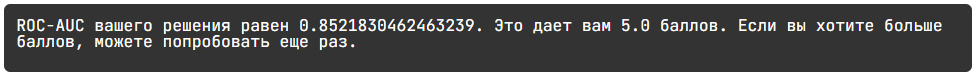

Далее установим достаточно малый шаг обучения: `learning_rate=0.01`. Параметры `iterations` и `l2_leaf_reg` оставим по умолчанию.

Чтобы снизить риск переобучения, ограничим долю признаков, участвующих в построении каждого дерева, с помощью параметра `rsm=0.9`. В данном случае это предпочтительнее, чем ограничивать долю объектов через `subsample`, поскольку позволяет контролировать сложность модели на уровне структуры деревьев, а не за счёт уменьшения объёма данных.

Уровень добавляемого шума (`random_strength`) также оставим по умолчанию $-$ он обеспечивает дополнительную регуляризацию без необходимости ручной настройки.

Наконец, выберем более сложную стратегию роста деревьев $-$ `grow_policy='Depthwise'`, которая строит деревья, углубляясь по уровням. Это может улучшить способность модели захватывать нелинейные зависимости в данных.
<br><br>
Получаем:

In [ ]:
X, Y = X_train, Y_train

model = CatBoostClassifier(
    verbose=False,
    cat_features=cat_features,
    random_state=RANDOM_STATE,
    eval_metric='AUC',
    one_hot_max_size=2,
    max_ctr_complexity=2,
    learning_rate=0.01,
    rsm=0.9,
    grow_policy='Depthwise'
)

cv_results = cross_validate(
    model,
    X, Y,
    cv=skf,
    scoring=['roc_auc', 'average_precision']
)

mean_roc_auc = cv_results['test_roc_auc'].mean()
std_roc_auc = cv_results['test_roc_auc'].std()

mean_pr_auc = cv_results['test_average_precision'].mean()
std_pr_auc = cv_results['test_average_precision'].std()

print(
    f'ROC AUC (cv={n_splits}):  {mean_roc_auc:.5f} \u00b1 {std_roc_auc:.5f}',
    f'PR AUC  (cv={n_splits}):  {mean_pr_auc:.5f} \u00b1 {std_pr_auc:.5f}',
    sep='\n', end=2*'\n'
)


# Формирование submission-файла
model.fit(X, Y)
predictions = model.predict_proba(X_test)[:, 1]
submission = pd.DataFrame({
    'Id': range(len(predictions)),
    'Churn': predictions
})
submission.to_csv('submission_catboost.csv', index=False)


# Важность признаков
pd.Series(
    model.get_feature_importance(),
    index=X.columns,
    name='Importance'
).sort_values(ascending=False)

ROC AUC (cv=5):  0.84460 ± 0.01963
PR AUC  (cv=5):  0.66339 ± 0.02147



,Importance
HasContractPhone,34.630250
ClientPeriod,11.824090
HasOnlineSecurityService,9.924269
HasInternetService,7.390664
TotalSpent,6.564885
HasTechSupportAccess,6.561094
PaymentMethod,4.861593
MonthlySpending,4.400834
HasOnlineBackup,3.133271
HasMovieSubscription,2.101276


Ответ проверяющей системы:

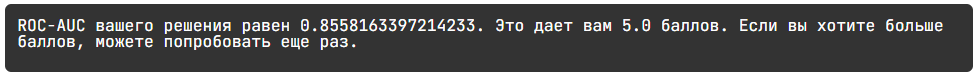